# Кейс задание на позицию Junior Data Scientist по прогнозированию прироста вкладов физических лиц, выполненное с использованием библиотек машинного обучения

In [1]:
# ! pip install ipywidgets
# ! pip install prophet
# ! pip install sktime
# ! pip install catboost
# ! pip install -U scikit-learn
# !jupyter nbextension enable --py widgetsnbextension
# ! jupyter nbextension enable --py widgetsnbextension

In [2]:
# pip install ipykernel==6.24.0

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# plt.style.use('dark_background')

from prophet import Prophet

from sktime.utils.plotting import plot_series

from prophet.plot import plot_plotly, plot_components_plotly

from catboost import CatBoostRegressor

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor


from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, average_precision_score
from sklearn.metrics import make_scorer

from sklearn.linear_model import LinearRegression

import datetime

# EDA

### Добавил Российский индекс волатильности RVI к признакам

In [4]:
df = pd.read_excel('data.xlsx')
rvi = pd.read_csv('candles.csv', sep=';',  skiprows = 1)
# rvi_ = pd.read_csv('security.csv', sep=';')

In [5]:
df= df.rename(columns={'Unnamed: 0':'Дата'})
df.head(10)

Дата  Прирост вкладов физических лиц в рублях (млн руб)  \
0 2011-01-01                                           -79049.0   
1 2011-02-01                                           180475.0   
2 2011-03-01                                           106845.0   
3 2011-04-01                                           224890.0   
4 2011-05-01                                            45856.0   
5 2011-06-01                                           227020.0   
6 2011-07-01                                           133756.0   
7 2011-08-01                                            10165.0   
8 2011-09-01                                            45398.0   
9 2011-10-01                                            17145.0   

   Доходность ОФЗ по сроку до 1 года  Ключевая ставка  \
0                           5.244667             7.75   
1                           5.144211             8.00   
2                           5.021364             8.00   
3                           4.558571             8.00   
4                           4.795000             8.25   
5                           4.934762             8.25   
6                           4.777619             8.25   
7                           5.215217             8.25   
8                           5.873636             8.25   
9                           6.443810             8.25   

   Ставка по вкладам в долларах до 1 года  \
0                                     2.9   
1                                     3.1   
2                                     3.1   
3                                     2.6   
4                                     2.6   
5                                     2.6   
6                                     2.6   
7                                     2.6   
8                                     2.5   
9                                     2.9   

   Ставка по вкладам в рублях до 1 года  Нефть марки Юралс, долл./барр  \
0                                   4.5                          96.29   
1                                   4.4                         103.96   
2                                   4.2                         114.44   
3                                   4.1                         123.15   
4                                   4.1                         114.46   
5                                   4.2                         113.76   
6                                   4.0                         116.46   
7                                   4.1                         110.08   
8                                   4.0                         110.88   
9                                   4.5                         109.47   

   Индекс потребительских цен, ед.  М0, млрд руб  М2, млрд руб  \
0                        106.17151        5062.7       20011.9   
1                        106.99964        4830.7       19307.7   
2                        107.66304        4898.0       19536.7   
3                        108.12599        4918.2       19788.7   
4                        108.64500        5071.3       20020.8   
5                        108.89488        5079.8       20160.9   
6                        108.88399        5192.2       20721.9   
7                        108.62267        5306.6       20828.1   
8                        108.57922        5343.0       21061.9   
9                        109.10040        5420.4       21480.4   

   Курс доллара к рублю, руб  Номинальная средняя з/п, руб  
0                      30.08                         20669  
1                      29.29                         20680  
2                      28.43                         22673  
3                      28.10                         22519  
4                      27.87                         22779  
5                      27.98                         24137  
6                      27.90                         23598  
7                      28.77                         23051  
8                      30.49                         23

In [6]:
rvi.head()

open  close   high    low  value  volume                begin  \
0  17.94  18.54  21.23  14.91      0       0  2017-12-01 00:00:00   
1  16.66  17.83  21.47  14.35      0       0  2017-11-01 00:00:00   
2  17.46  17.07  18.28  13.80      0       0  2017-10-01 00:00:00   
3  19.84  17.90  21.34  15.92      0       0  2017-09-01 00:00:00   
4  22.96  19.80  23.50  17.88      0       0  2017-08-01 00:00:00   

                   end  
0  2017-12-29 00:00:00  
1  2017-11-30 00:00:00  
2  2017-10-31 00:00:00  
3  2017-09-30 00:00:00  
4  2017-08-31 00:00:00

In [7]:
df.dtypes

Дата                                                 datetime64[ns]
Прирост вкладов физических лиц в рублях (млн руб)           float64
Доходность ОФЗ по сроку до 1 года                           float64
Ключевая ставка                                             float64
Ставка по вкладам в долларах до 1 года                      float64
Ставка по вкладам в рублях до 1 года                        float64
Нефть марки Юралс, долл./барр                               float64
Индекс потребительских цен, ед.                             float64
М0, млрд руб                                                float64
М2, млрд руб                                                float64
Курс доллара к рублю, руб                                   float64
Номинальная средняя з/п, руб                                  int64
dtype: object

In [8]:
rvi.dtypes

open      float64
close     float64
high      float64
low       float64
value       int64
volume      int64
begin      object
end        object
dtype: object

In [9]:
rvi = rvi.drop(columns=['end','value', 'volume'])

In [10]:
rvi['begin'] = pd.to_datetime(rvi['begin'],
               format='%Y-%m-%d %H:%M:%S.%f')
rvi = rvi.rename(columns={'begin':'Дата'})

In [11]:
rvi.head()

open  close   high    low       Дата
0  17.94  18.54  21.23  14.91 2017-12-01
1  16.66  17.83  21.47  14.35 2017-11-01
2  17.46  17.07  18.28  13.80 2017-10-01
3  19.84  17.90  21.34  15.92 2017-09-01
4  22.96  19.80  23.50  17.88 2017-08-01

In [12]:
df_left = df.merge(rvi, on='Дата', how = 'left')

### от 2011 до 2013-11 не буду использовать данные т.к. RVI тех лет отсутствует + последние данные являются более актуальными для исследования

In [13]:
df = df.merge(rvi, on='Дата', how = 'inner')

In [14]:
df.isna().mean()

Дата                                                 0.00
Прирост вкладов физических лиц в рублях (млн руб)    0.24
Доходность ОФЗ по сроку до 1 года                    0.00
Ключевая ставка                                      0.00
Ставка по вкладам в долларах до 1 года               0.00
Ставка по вкладам в рублях до 1 года                 0.00
Нефть марки Юралс, долл./барр                        0.00
Индекс потребительских цен, ед.                      0.00
М0, млрд руб                                         0.00
М2, млрд руб                                         0.00
Курс доллара к рублю, руб                            0.00
Номинальная средняя з/п, руб                         0.00
open                                                 0.00
close                                                0.00
high                                                 0.00
low                                                  0.00
dtype: float64

In [15]:
df.dtypes

Дата                                                 datetime64[ns]
Прирост вкладов физических лиц в рублях (млн руб)           float64
Доходность ОФЗ по сроку до 1 года                           float64
Ключевая ставка                                             float64
Ставка по вкладам в долларах до 1 года                      float64
Ставка по вкладам в рублях до 1 года                        float64
Нефть марки Юралс, долл./барр                               float64
Индекс потребительских цен, ед.                             float64
М0, млрд руб                                                float64
М2, млрд руб                                                float64
Курс доллара к рублю, руб                                   float64
Номинальная средняя з/п, руб                                  int64
open                                                        float64
close                                                       float64
high                                            

In [16]:
df.describe()

Прирост вкладов физических лиц в рублях (млн руб)  \
count                                       3.800000e+01   
mean                                        1.416418e+05   
std                                         3.033917e+05   
min                                        -5.674480e+05   
25%                                         1.151500e+04   
50%                                         1.258960e+05   
75%                                         2.205480e+05   
max                                         1.034556e+06   

       Доходность ОФЗ по сроку до 1 года  Ключевая ставка  \
count                          50.000000        50.000000   
mean                            9.200278         9.910000   
std                             1.866094         2.548389   
min                             6.154000         5.500000   
25%                             7.958762         8.062500   
50%                             8.974951        10.000000   
75%                            10.274783        11.000000   
max                            15.098421        17.000000   

       Ставка по вкладам в долларах до 1 года  \
count                               50.000000   
mean                                 1.762200   
std                                  1.261253   
min                                  0.520000   
25%                                  0.775000   
50%                                  1.625000   
75%                                  1.972500   
max                                  5.220000   

       Ставка по вкладам в рублях до 1 года  Нефть марки Юралс, долл./барр  \
count                             50.000000                      50.000000   
mean                               6.939000                      64.391400   
std                                1.868902                      24.877867   
min                                5.000000                      30.800000   
25%                                5.640000                      47.155000   
50%                                6.275000                      55.190000   
75%                                7.677500                      75.055000   
max                               12.330000                     111.870000   

       Индекс потребительских цен, ед.  М0, млрд руб  М2, млрд руб  \
count                        50.000000     50.000000     50.000000   
mean                        152.114721   7150.465604  33896.553897   
std                          15.302029    488.209833   3641.763202   
min                         124.207680   6419.000000  28276.400000   
25%                         136.363902   6760.194233  30511.235312   
50%                         156.372005   7020.370413  32552.980370   
75%                         165.244430   7456.415989  36367.123236   
max                         169.560950   8089.527215  40114.408278   

       Курс доллара к рублю, руб  Номинальная средняя з/п, руб       open  \
count                  50.000000                     50.000000  50.000000   
mean                   55.242600                  35591.860000  32.093400   
std                    12.556516                   4298.278236  10.323046   
min                    32.640000                  29255.000000  16.660000   
25%                    47.040000                  32570.000000  24.082500   
50%                    58.490000                  34908.500000  31.465000   
75%                    64.540000                  38010.000000  37.162500   
max                    77.220000                  50500.000000  67.190000   

           close       high        low  
count  50.000000   50.00000  50.000000  
mean   31.928000   39.70500  26.999800  
std    10.275138   17.47964   7.936642  
min    17.070000   18.28000  13.800000  
25%    24.000000   27.96000  20.987500  
50%    31.655000   37.43000  27.020000  
75%    36.357500   45.38000  31.430000  
max    66.200000  121.41000  49.490000

### Посмотрю корелляции между переменными

P.S. хорошая корелляция между приростом вкладом физических лиц и ['Нефть марки Юралс','Индекс потребительских цен, ед.', 'М0, млрд руб', 'М2, млрд руб', 'Курс доллара к рублю, руб', 'Номинальная средняя з/п, руб','close', 'high', 'low', 'Месяц']

/var/folders/0k/w2d250bd1439pcb67w1jhq840000gn/T/ipykernel_72274/1197322881.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), xticklabels=df.corr().columns, yticklabels=df.corr().columns, center=0, annot=True, cmap = 'Blues')


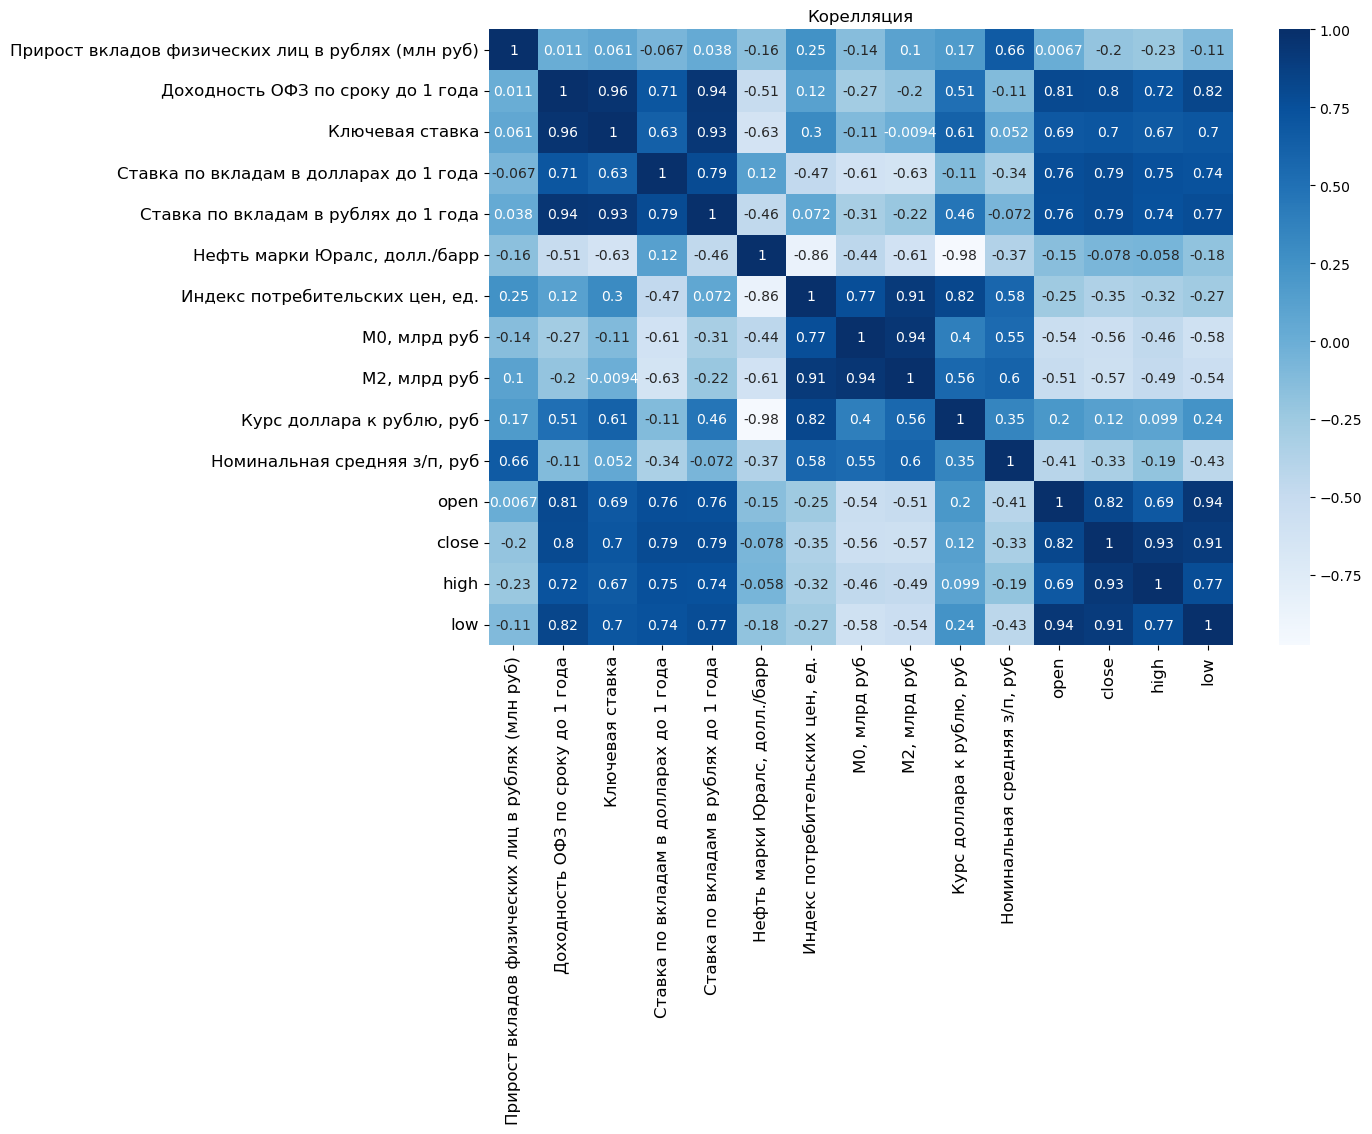

In [17]:
plt.figure(figsize=(12,8), dpi= 100)
sns.heatmap(df.corr(), xticklabels=df.corr().columns, yticklabels=df.corr().columns, center=0, annot=True, cmap = 'Blues')
plt.title('Корелляция')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [18]:
df.columns

Index(['Дата', 'Прирост вкладов физических лиц в рублях (млн руб)',
       'Доходность ОФЗ по сроку до 1 года', 'Ключевая ставка',
       'Ставка по вкладам в долларах до 1 года',
       'Ставка по вкладам в рублях до 1 года', 'Нефть марки Юралс, долл./барр',
       'Индекс потребительских цен, ед.', 'М0, млрд руб', 'М2, млрд руб',
       'Курс доллара к рублю, руб', 'Номинальная средняя з/п, руб', 'open',
       'close', 'high', 'low'],
      dtype='object')

In [19]:
df.tail(13)

Дата  Прирост вкладов физических лиц в рублях (млн руб)  \
37 2016-12-01                                           889085.0   
38 2017-01-01                                                NaN   
39 2017-02-01                                                NaN   
40 2017-03-01                                                NaN   
41 2017-04-01                                                NaN   
42 2017-05-01                                                NaN   
43 2017-06-01                                                NaN   
44 2017-07-01                                                NaN   
45 2017-08-01                                                NaN   
46 2017-09-01                                                NaN   
47 2017-10-01                                                NaN   
48 2017-11-01                                                NaN   
49 2017-12-01                                                NaN   

    Доходность ОФЗ по сроку до 1 года  Ключевая ставка  \
37                           8.659545            10.00   
38                           8.416190            10.00   
39                           8.830526            10.00   
40                           8.987727             9.75   
41                           8.655263             9.75   
42                           8.319500             9.25   
43                           8.039048             9.00   
44                           8.074286             9.00   
45                           7.882174             9.00   
46                           7.648095             8.50   
47                           7.503636             8.25   
48                           7.381429             8.25   
49                           6.978095             7.75   

    Ставка по вкладам в долларах до 1 года  \
37                                    0.76   
38                                    0.79   
39                                    0.77   
40                                    0.80   
41                                    0.52   
42                                    0.76   
43                                    0.71   
44                                    0.66   
45                                    0.73   
46                                    0.66   
47                                    0.61   
48                                    0.64   
49                                    0.73   

    Ставка по вкладам в рублях до 1 года  Нефть марки Юралс, долл./барр  \
37                                  6.50                          54.07   
38                                  6.50                          54.89   
39                                  6.30                          55.49   
40                                  5.91                          51.97   
41                                  6.25                          53.06   
42                                  6.10                          50.87   
43                                  5.70                          46.89   
44                                  6.07                          48.50   
45                                  6.07                          52.00   
46                                  5.31                          57.00   
47                                  5.67                          57.50   
48                                  5.18                          63.10   
49                                  5.27                          64.90   

    Индекс потребительских цен, ед.  М0, млрд руб  М2, млрд руб  \
37                       165.409180   7317.233222  36432.971673   
38                       166.434720   7714.777071  38417.973904   
39                       166.800870   7543.682136  38016.827597   
40                       167.017720   7587.379089  38462.292674   
41                       167.568870   7610.346801  38555.203677   
42                       168.188880   7775.286453  38663.774533   
43                       169.214830   7813.342742  39222.853872   
44         

### Визуализирую корелляцию между номинальной средней з/п и приростом вкладов

In [20]:
df['salary_bin'] = pd.qcut(df['Номинальная средняя з/п, руб'],4)

<Axes: xlabel='salary_bin'>

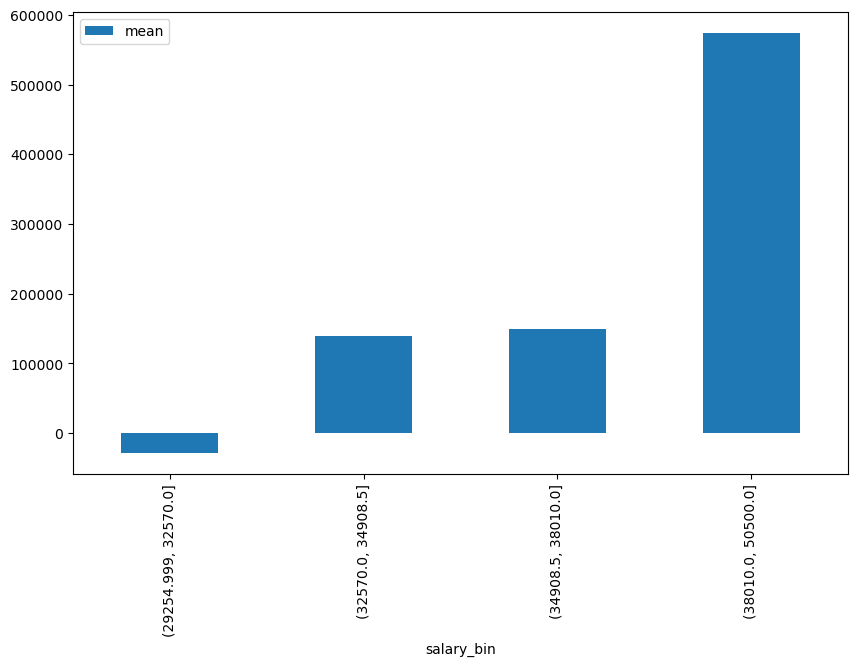

In [21]:
df.groupby('salary_bin',dropna=False)['Прирост вкладов физических лиц в рублях (млн руб)']\
    .agg(['mean']).plot(figsize=(10,6), kind = 'bar')

In [22]:
df.columns

Index(['Дата', 'Прирост вкладов физических лиц в рублях (млн руб)',
       'Доходность ОФЗ по сроку до 1 года', 'Ключевая ставка',
       'Ставка по вкладам в долларах до 1 года',
       'Ставка по вкладам в рублях до 1 года', 'Нефть марки Юралс, долл./барр',
       'Индекс потребительских цен, ед.', 'М0, млрд руб', 'М2, млрд руб',
       'Курс доллара к рублю, руб', 'Номинальная средняя з/п, руб', 'open',
       'close', 'high', 'low', 'salary_bin'],
      dtype='object')

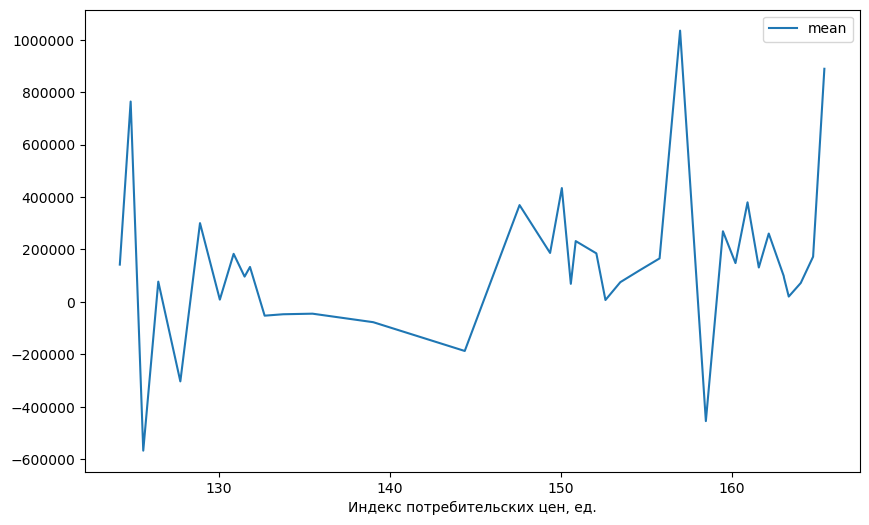

In [23]:
df.groupby('Индекс потребительских цен, ед.',dropna=False)['Прирост вкладов физических лиц в рублях (млн руб)'] \
    .agg(['mean']).plot(figsize=(10,6))
plt.ticklabel_format(style='plain', axis='y')

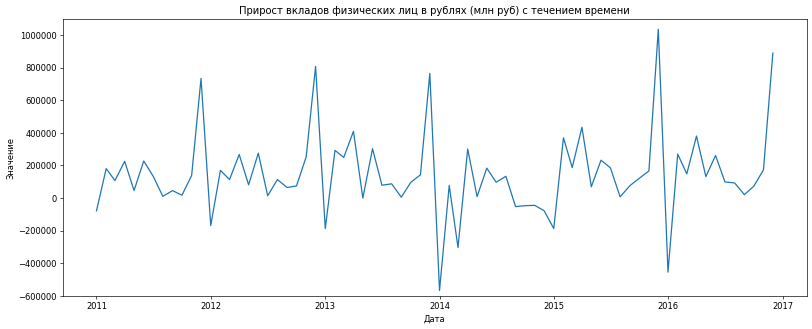

In [24]:
plt.figure(figsize=(16,6), dpi= 60)

# Построение графика
# plt.plot(df['Дата'], df['Номинальная средняя з/п, руб'], label='Номинальная средняя з/п, руб')
plt.plot(df_left['Дата'], df_left['Прирост вкладов физических лиц в рублях (млн руб)']
         # , label='Прирост вкладов физических лиц в рублях (млн руб)'
        )
plt.ylim(-600000, 1100000)
# Настройки графика
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.title('Прирост вкладов физических лиц в рублях (млн руб) с течением времени')
# plt.legend()
plt.ticklabel_format(style='plain', axis='y')
# Отображение графика
plt.show()


# Models

In [25]:
df_ = df_left[df_left['Дата']<='2016-12-01']
df_

Дата  Прирост вкладов физических лиц в рублях (млн руб)  \
0  2011-01-01                                           -79049.0   
1  2011-02-01                                           180475.0   
2  2011-03-01                                           106845.0   
3  2011-04-01                                           224890.0   
4  2011-05-01                                            45856.0   
..        ...                                                ...   
67 2016-08-01                                            92168.0   
68 2016-09-01                                            20272.0   
69 2016-10-01                                            72037.0   
70 2016-11-01                                           172323.0   
71 2016-12-01                                           889085.0   

    Доходность ОФЗ по сроку до 1 года  Ключевая ставка  \
0                            5.244667             7.75   
1                            5.144211             8.00   
2                            5.021364             8.00   
3                            4.558571             8.00   
4                            4.795000             8.25   
..                                ...              ...   
67                           9.274348            10.50   
68                           9.015000            10.00   
69                           9.002381            10.00   
70                           8.936190            10.00   
71                           8.659545            10.00   

    Ставка по вкладам в долларах до 1 года  \
0                                     2.90   
1                                     3.10   
2                                     3.10   
3                                     2.60   
4                                     2.60   
..                                     ...   
67                                    0.89   
68                                    0.82   
69                                    0.71   
70                                    0.72   
71                                    0.76   

    Ставка по вкладам в рублях до 1 года  Нефть марки Юралс, долл./барр  \
0                                   4.50                          96.29   
1                                   4.40                         103.96   
2                                   4.20                         114.44   
3                                   4.10                         123.15   
4                                   4.10                         114.46   
..                                   ...                            ...   
67                                  6.77                          46.14   
68                                  6.00                          46.19   
69                                  6.01                          49.73   
70                                  6.62                          46.44   
71                                  6.50                          54.07   

    Индекс потребительских цен, ед.  М0, млрд руб  М2, млрд руб  \
0                         106.17151   5062.700000  20011.900000   
1                         106.99964   4830.700000  19307.700000   
2                         107.66304   4898.000000  19536.700000   
3                         108.12599   4918.200000  19788.700000   
4                         108.64500   5071.300000  20020.800000   
..                              ...           ...           ...   
67                        163.04897   7462.394809  36031.670782   
68                        163.32615   7438.479529  36169.577926   
69                        164.02846   7412.196989  36148.750479   
70                        164.75018   7339.148803  36051.043468   
71                        165.40918   7317.233222  36432.971673   

    Курс доллара к рублю, руб  Номинальная средняя з/п, руб   open  close  \
0                       30.08                         20669    NaN    NaN   
1                       29.29                         20680    NaN    NaN   
2    

In [26]:
df_ = df_.rename(columns={'Дата':'ds', 'Прирост вкладов физических лиц в рублях (млн руб)':'y'})
df_.tail(12)

ds         y  Доходность ОФЗ по сроку до 1 года  Ключевая ставка  \
60 2016-01-01 -454791.0                          10.308889             11.0   
61 2016-02-01  269297.0                           9.930476             11.0   
62 2016-03-01  147971.0                           9.505909             11.0   
63 2016-04-01  379759.0                           9.701905             11.0   
64 2016-05-01  131129.0                           9.538947             11.0   
65 2016-06-01  260591.0                           9.752857             10.5   
66 2016-07-01   98589.0                           9.606667             10.5   
67 2016-08-01   92168.0                           9.274348             10.5   
68 2016-09-01   20272.0                           9.015000             10.0   
69 2016-10-01   72037.0                           9.002381             10.0   
70 2016-11-01  172323.0                           8.936190             10.0   
71 2016-12-01  889085.0                           8.659545             10.0   

    Ставка по вкладам в долларах до 1 года  \
60                                    1.58   
61                                    1.62   
62                                    1.59   
63                                    1.30   
64                                    1.19   
65                                    0.97   
66                                    0.87   
67                                    0.89   
68                                    0.82   
69                                    0.71   
70                                    0.72   
71                                    0.76   

    Ставка по вкладам в рублях до 1 года  Нефть марки Юралс, долл./барр  \
60                                  8.20                          30.80   
61                                  7.68                          33.20   
62                                  7.46                          39.07   
63                                  7.67                          42.25   
64                                  7.04                          47.13   
65                                  6.92                          48.48   
66                                  6.78                          45.07   
67                                  6.77                          46.14   
68                                  6.00                          46.19   
69                                  6.01                          49.73   
70                                  6.62                          46.44   
71                                  6.50                          54.07   

    Индекс потребительских цен, ед.  М0, млрд руб  М2, млрд руб  \
60                        158.47866   7239.145905  35179.714815   
61                        159.47707   7055.140825  33966.453991   
62                        160.21067   7149.795460  34309.649661   
63                        160.91559   7142.892260  34689.448390   
64                        161.57535   7301.487971  35105.469375   
65                        162.15702   7296.764604  35642.933649   
66                        163.03267   7372.703720  35856.891826   
67                        163.04897   7462.394809  36031.670782   
68                        163.32615   7438.479529  36169.577926   
69                        164.02846   7412.196989  36148.750479   
70                        164.75018   7339.148803  36051.043468   
71                        165.40918   7317.233222  36432.971673   

    Курс доллара к рублю, руб  Номинальная средняя з/п, руб   open  close  \
60                      76.25                         32660  37.36  41.20   
61                      77.22                         33873  41.18  43.25   
62                      70.47                         35501  43.53  34.39   
63                      66.68                         36497  35.52  35.33   
64                      65.66                         37270  35.56  33.63   
65                      65.31                         38447  33.61  34.18 

## Prophet

In [27]:
m = Prophet()
m.fit(df_)

20:29:29 - cmdstanpy - INFO - Chain [1] start processing
20:29:30 - cmdstanpy - INFO - Chain [1] done processing


In [28]:
future = m.make_future_dataframe(periods=13, freq = 'M')
future.tail()

ds
80 2017-08-31
81 2017-09-30
82 2017-10-31
83 2017-11-30
84 2017-12-31

In [29]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12)

ds           yhat     yhat_lower     yhat_upper
73 2017-01-31  265532.712772   83346.795287  425474.426836
74 2017-02-28   35530.533068 -136186.068763  203201.198313
75 2017-03-31  346699.597994  167796.082791  507444.867946
76 2017-04-30   22986.032328 -160828.622428  191585.307584
77 2017-05-31  204293.853877   39254.090488  370481.747832
78 2017-06-30  240203.296994   67935.435690  419015.647381
79 2017-07-31    4840.221291 -182035.402827  168535.505911
80 2017-08-31   72538.234745  -98113.923610  246059.703000
81 2017-09-30   67032.546579 -117457.849947  240173.637675
82 2017-10-31   84095.212131  -84401.589975  263253.200004
83 2017-11-30  631924.256670  467060.558404  803938.131778
84 2017-12-31 -186432.954619 -374075.318386   -5356.943941

In [30]:
pred_prophet = forecast.loc[forecast['ds']>='2016-12-01',['ds', 'yhat']].set_index('ds')

In [31]:
pred_prophet

yhat
ds                       
2016-12-01  723892.645512
2016-12-31 -214505.366016
2017-01-31  265532.712772
2017-02-28   35530.533068
2017-03-31  346699.597994
2017-04-30   22986.032328
2017-05-31  204293.853877
2017-06-30  240203.296994
2017-07-31    4840.221291
2017-08-31   72538.234745
2017-09-30   67032.546579
2017-10-31   84095.212131
2017-11-30  631924.256670
2017-12-31 -186432.954619

In [32]:
PRED_prophet = pred_prophet['yhat'].tail(12).values
PRED_prophet

array([ 265532.7127723 ,   35530.53306813,  346699.5979939 ,
         22986.03232839,  204293.85387677,  240203.29699416,
          4840.22129068,   72538.23474454,   67032.54657902,
         84095.21213096,  631924.25666978, -186432.95461949])

In [33]:
old = df.loc[df['Дата']<='2016-12-01',['Дата', 'Прирост вкладов физических лиц в рублях (млн руб)']].set_index('Дата')
old.shape

(38, 1)

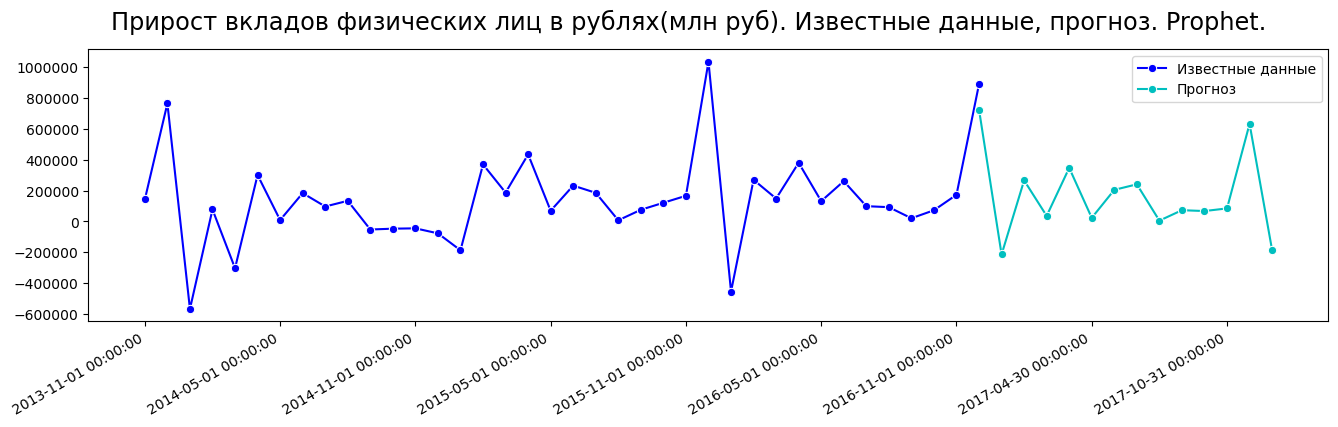

In [34]:
fig, ax = plot_series(old, pred_prophet, colors = ['b', 'c'],
      title = 'Прирост вкладов физических лиц в рублях(млн руб). Известные данные, прогноз. Prophet.', labels = ['Известные данные', 'Прогноз'])
plt.ticklabel_format(style='plain', axis='y')
fig.autofmt_xdate()

In [35]:
plot_plotly(m, forecast)

In [36]:
plot_components_plotly(m, forecast)

### В декабре пик, в январе резкое падение. Вероятно вследствие выплаты "13 зарплаты"

---
### Тренд восходящий


In [37]:
df['Месяц'] = pd.DatetimeIndex(df['Дата']).month

In [38]:
# df['Год'] = pd.DatetimeIndex(df['Дата']).year
# Год тоже пробовал добавлять, но он существенных изменений не принёс

In [39]:
df = df.drop(columns='salary_bin')

## Catboost

In [40]:
df.head()

Дата  Прирост вкладов физических лиц в рублях (млн руб)  \
0 2013-11-01                                           142125.0   
1 2013-12-01                                           764180.0   
2 2014-01-01                                          -567448.0   
3 2014-02-01                                            77197.0   
4 2014-03-01                                          -303341.0   

   Доходность ОФЗ по сроку до 1 года  Ключевая ставка  \
0                           6.154000              5.5   
1                           6.242857              5.5   
2                           6.183684              5.5   
3                           6.356500              5.5   
4                           7.397500              7.0   

   Ставка по вкладам в долларах до 1 года  \
0                                    2.10   
1                                    2.30   
2                                    2.01   
3                                    1.84   
4                                    1.66   

   Ставка по вкладам в рублях до 1 года  Нефть марки Юралс, долл./барр  \
0                                  5.00                         108.08   
1                                  5.10                         110.63   
2                                  5.30                         107.57   
3                                  5.09                         108.81   
4                                  5.07                         107.41   

   Индекс потребительских цен, ед.  М0, млрд руб  М2, млрд руб  \
0                        124.20768        6419.0       28276.4   
1                        124.84114        6564.1       28873.3   
2                        125.57770        6985.6       31155.6   
3                        126.45675        6663.1       29861.2   
4                        127.74660        6699.9       30169.0   

   Курс доллара к рублю, руб  Номинальная средняя з/п, руб   open  close  \
0                      32.64                         30290  23.80  23.80   
1                      32.89                         39648  23.83  20.48   
2                      33.46                         29535  20.47  27.48   
3                      35.22                         29255  27.47  28.38   
4                      36.21                         31486  28.35  38.84   

    high    low  Месяц  
0  24.43  20.98     11  
1  26.49  17.33     12  
2  29.04  17.18      1  
3  29.84  24.37      2  
4  70.63  27.88      3

In [41]:
df_train_val = df[df['Дата']<='2016-12-01']

In [42]:
df_predict = df[df['Дата']>'2016-12-01']

In [43]:
df_predict

Дата  Прирост вкладов физических лиц в рублях (млн руб)  \
38 2017-01-01                                                NaN   
39 2017-02-01                                                NaN   
40 2017-03-01                                                NaN   
41 2017-04-01                                                NaN   
42 2017-05-01                                                NaN   
43 2017-06-01                                                NaN   
44 2017-07-01                                                NaN   
45 2017-08-01                                                NaN   
46 2017-09-01                                                NaN   
47 2017-10-01                                                NaN   
48 2017-11-01                                                NaN   
49 2017-12-01                                                NaN   

    Доходность ОФЗ по сроку до 1 года  Ключевая ставка  \
38                           8.416190            10.00   
39                           8.830526            10.00   
40                           8.987727             9.75   
41                           8.655263             9.75   
42                           8.319500             9.25   
43                           8.039048             9.00   
44                           8.074286             9.00   
45                           7.882174             9.00   
46                           7.648095             8.50   
47                           7.503636             8.25   
48                           7.381429             8.25   
49                           6.978095             7.75   

    Ставка по вкладам в долларах до 1 года  \
38                                    0.79   
39                                    0.77   
40                                    0.80   
41                                    0.52   
42                                    0.76   
43                                    0.71   
44                                    0.66   
45                                    0.73   
46                                    0.66   
47                                    0.61   
48                                    0.64   
49                                    0.73   

    Ставка по вкладам в рублях до 1 года  Нефть марки Юралс, долл./барр  \
38                                  6.50                          54.89   
39                                  6.30                          55.49   
40                                  5.91                          51.97   
41                                  6.25                          53.06   
42                                  6.10                          50.87   
43                                  5.70                          46.89   
44                                  6.07                          48.50   
45                                  6.07                          52.00   
46                                  5.31                          57.00   
47                                  5.67                          57.50   
48                                  5.18                          63.10   
49                                  5.27                          64.90   

    Индекс потребительских цен, ед.  М0, млрд руб  М2, млрд руб  \
38                       166.434720   7714.777071  38417.973904   
39                       166.800870   7543.682136  38016.827597   
40                       167.017720   7587.379089  38462.292674   
41                       167.568870   7610.346801  38555.203677   
42                       168.188880   7775.286453  38663.774533   
43                       169.214830   7813.342742  39222.853872   
44                       169.333280   7946.920837  39623.111354   
45                       168.418880   8034.188296  39275.911028   
46                       168.166250   8066.772110  39419.314228   
47                       168.502590   8089.527215  39570.988535   
48                       168.852459   8071.528889  39667.

In [44]:
y = df_train_val['Прирост вкладов физических лиц в рублях (млн руб)']
X = df_train_val.drop(columns = ['Прирост вкладов физических лиц в рублях (млн руб)'])
X_predict = df_predict.drop(columns = ['Прирост вкладов физических лиц в рублях (млн руб)'])

In [45]:
X_tr, X_val, y_tr, y_val = train_test_split(X, y, train_size=0.70, random_state=42, shuffle=False)

In [46]:
model_0 = CatBoostRegressor(loss_function='RMSE',
   learning_rate=0.1, iterations = 1000, depth = 3,
    random_seed=42
)

In [47]:
model_0.fit(
    X_tr, y_tr, use_best_model=True,
    eval_set=(X_val, y_val),
    logging_level='Silent')

In [48]:
SCORE_catboost_0 = model_0.get_best_score()['validation']['RMSE']
SCORE_catboost_0

282762.8927283482

### RMSE = 282762.8927283482
### MAPE = 0.6884360175

In [49]:
fi_catboost_0 = pd.DataFrame({'name': X_tr.columns,'weight': model_0.feature_importances_})
fi_catboost_0.sort_values('weight',ascending=False,inplace=True)

### Feature importances Catboost

In [50]:
fi_catboost_0

name     weight
10            Номинальная средняя з/п, руб  22.402802
7                             М0, млрд руб  20.598905
15                                   Месяц   8.030945
13                                    high   6.629444
11                                    open   6.389310
6          Индекс потребительских цен, ед.   6.061837
5            Нефть марки Юралс, долл./барр   5.348740
0                                     Дата   4.153810
8                             М2, млрд руб   3.335795
3   Ставка по вкладам в долларах до 1 года   3.159604
2                          Ключевая ставка   3.089068
12                                   close   3.049520
4     Ставка по вкладам в рублях до 1 года   2.700692
14                                     low   2.369217
1        Доходность ОФЗ по сроку до 1 года   1.845764
9                Курс доллара к рублю, руб   0.834547

In [51]:
PRED_catboost_0 = model_0.predict(X_predict)

In [52]:
pd.Series(PRED_catboost_0)

0      29041.043226
1     120213.667826
2     290798.298718
3     281098.459912
4     237330.860212
5     310461.908121
6     295442.184927
7     155146.305515
8     159693.358501
9     179220.008664
10    159693.358501
11    269420.716588
dtype: float64

In [53]:
df.loc[df['Дата']>'2016-12-01','Прирост вкладов физических лиц в рублях (млн руб)'] = PRED_catboost_0

In [54]:
df.loc[df['Дата']>'2016-12-01','Прирост вкладов физических лиц в рублях (млн руб)']

38     29041.043226
39    120213.667826
40    290798.298718
41    281098.459912
42    237330.860212
43    310461.908121
44    295442.184927
45    155146.305515
46    159693.358501
47    179220.008664
48    159693.358501
49    269420.716588
Name: Прирост вкладов физических лиц в рублях (млн руб), dtype: float64

### Визуализирую известные данные и прогноз

In [55]:
old = df.loc[df['Дата']<='2016-12-01',['Дата', 'Прирост вкладов физических лиц в рублях (млн руб)']].set_index('Дата')
old.shape

(38, 1)

In [56]:
pred_0 = df.loc[df['Дата']>='2016-12-01',['Дата', 'Прирост вкладов физических лиц в рублях (млн руб)']].set_index('Дата')
pred_0.shape

(13, 1)

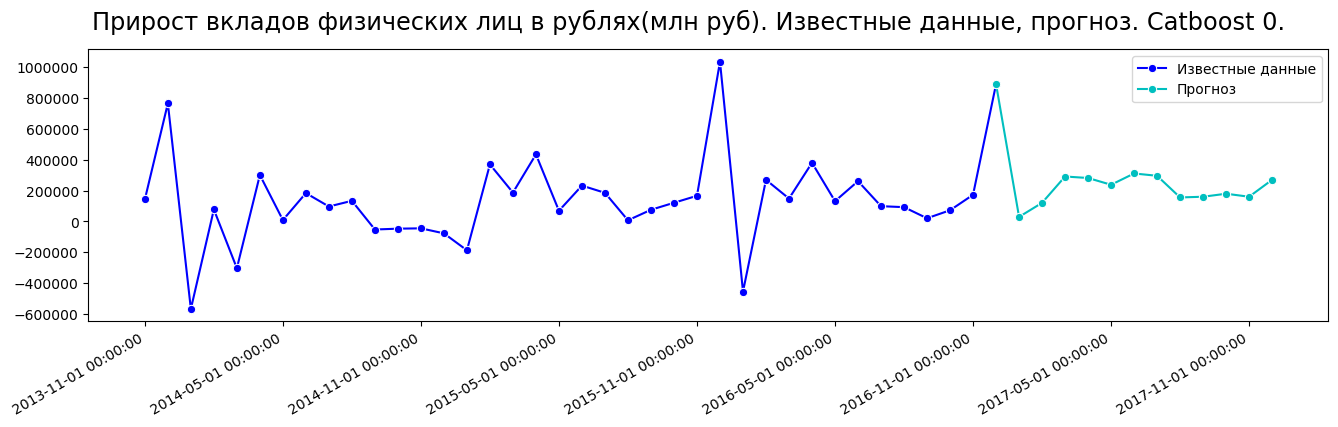

In [57]:
fig, ax = plot_series(old, pred_0, colors = ['b', 'c'],
      title = 'Прирост вкладов физических лиц в рублях(млн руб). Известные данные, прогноз. Catboost 0.', labels = ['Известные данные', 'Прогноз'])
plt.ticklabel_format(style='plain', axis='y')
fig.autofmt_xdate()

In [58]:
df.tail(12)

Дата  Прирост вкладов физических лиц в рублях (млн руб)  \
38 2017-01-01                                       29041.043226   
39 2017-02-01                                      120213.667826   
40 2017-03-01                                      290798.298718   
41 2017-04-01                                      281098.459912   
42 2017-05-01                                      237330.860212   
43 2017-06-01                                      310461.908121   
44 2017-07-01                                      295442.184927   
45 2017-08-01                                      155146.305515   
46 2017-09-01                                      159693.358501   
47 2017-10-01                                      179220.008664   
48 2017-11-01                                      159693.358501   
49 2017-12-01                                      269420.716588   

    Доходность ОФЗ по сроку до 1 года  Ключевая ставка  \
38                           8.416190            10.00   
39                           8.830526            10.00   
40                           8.987727             9.75   
41                           8.655263             9.75   
42                           8.319500             9.25   
43                           8.039048             9.00   
44                           8.074286             9.00   
45                           7.882174             9.00   
46                           7.648095             8.50   
47                           7.503636             8.25   
48                           7.381429             8.25   
49                           6.978095             7.75   

    Ставка по вкладам в долларах до 1 года  \
38                                    0.79   
39                                    0.77   
40                                    0.80   
41                                    0.52   
42                                    0.76   
43                                    0.71   
44                                    0.66   
45                                    0.73   
46                                    0.66   
47                                    0.61   
48                                    0.64   
49                                    0.73   

    Ставка по вкладам в рублях до 1 года  Нефть марки Юралс, долл./барр  \
38                                  6.50                          54.89   
39                                  6.30                          55.49   
40                                  5.91                          51.97   
41                                  6.25                          53.06   
42                                  6.10                          50.87   
43                                  5.70                          46.89   
44                                  6.07                          48.50   
45                                  6.07                          52.00   
46                                  5.31                          57.00   
47                                  5.67                          57.50   
48                                  5.18                          63.10   
49                                  5.27                          64.90   

    Индекс потребительских цен, ед.  М0, млрд руб  М2, млрд руб  \
38                       166.434720   7714.777071  38417.973904   
39                       166.800870   7543.682136  38016.827597   
40                       167.017720   7587.379089  38462.292674   
41                       167.568870   7610.346801  38555.203677   
42                       168.188880   7775.286453  38663.774533   
43                       169.214830   7813.342742  39222.853872   
44                       169.333280   7946.920837  39623.111354   
45                       168.418880   8034.188296  39275.911028   
46                       168.166250   8066.772110  39419.314228   
47                       168.502590   8089.527215  39570.988535   
48                       168.852459   8071.528889  39667.

In [59]:
model_0.get_best_score()

{'learn': {'RMSE': 0.4752964654890375},
 'validation': {'RMSE': 282762.8927283482}}

In [60]:
model_0.score(X_val, y_val)

0.05431436671710477

In [61]:
X.columns

Index(['Дата', 'Доходность ОФЗ по сроку до 1 года', 'Ключевая ставка',
       'Ставка по вкладам в долларах до 1 года',
       'Ставка по вкладам в рублях до 1 года', 'Нефть марки Юралс, долл./барр',
       'Индекс потребительских цен, ед.', 'М0, млрд руб', 'М2, млрд руб',
       'Курс доллара к рублю, руб', 'Номинальная средняя з/п, руб', 'open',
       'close', 'high', 'low', 'Месяц'],
      dtype='object')

### Удалю незначимые переменные

In [62]:
df_clean = df[['Дата','Прирост вкладов физических лиц в рублях (млн руб)','Нефть марки Юралс, долл./барр','Индекс потребительских цен, ед.', \
             'М0, млрд руб', 'М2, млрд руб','Курс доллара к рублю, руб', 'Номинальная средняя з/п, руб', 'close', 'high', 'low', 'Месяц',
             #'Год'
               ]]

In [63]:
df_clean.head(13)

Дата  Прирост вкладов физических лиц в рублях (млн руб)  \
0  2013-11-01                                           142125.0   
1  2013-12-01                                           764180.0   
2  2014-01-01                                          -567448.0   
3  2014-02-01                                            77197.0   
4  2014-03-01                                          -303341.0   
5  2014-04-01                                           300439.0   
6  2014-05-01                                             8596.0   
7  2014-06-01                                           183236.0   
8  2014-07-01                                            96407.0   
9  2014-08-01                                           133248.0   
10 2014-09-01                                           -52627.0   
11 2014-10-01                                           -47208.0   
12 2014-11-01                                           -45024.0   

    Нефть марки Юралс, долл./барр  Индекс потребительских цен, ед.  \
0                          108.08                        124.20768   
1                          110.63                        124.84114   
2                          107.57                        125.57770   
3                          108.81                        126.45675   
4                          107.41                        127.74660   
5                          107.88                        128.89632   
6                          109.68                        130.05639   
7                          111.87                        130.86274   
8                          106.98                        131.50397   
9                          101.92                        131.81958   
10                          97.34                        132.67640   
11                          87.27                        133.76435   
12                          78.44                        135.47653   

    М0, млрд руб  М2, млрд руб  Курс доллара к рублю, руб  \
0       6419.000       28276.4                      32.64   
1       6564.100       28873.3                      32.89   
2       6985.600       31155.6                      33.46   
3       6663.100       29861.2                      35.22   
4       6699.900       30169.0                      36.21   
5       6608.200       29519.3                      35.66   
6       6776.800       29879.2                      34.93   
7       6763.100       29890.8                      34.41   
8       6762.198       30071.8                      34.64   
9       6871.200       30178.3                      36.11   
10      6964.100       30338.7                      37.87   
11      6959.300       30297.6                      40.76   
12      6907.600       29831.2                      45.86   

    Номинальная средняя з/п, руб  close   high    low  Месяц  
0                          30290  23.80  24.43  20.98     11  
1                          39648  20.48  26.49  17.33     12  
2                          29535  27.48  29.04  17.18      1  
3                          29255  28.38  29.84  24.37      2  
4                          31486  38.84  70.63  27.88      3  
5                          32947  41.35  49.11  32.88      4  
6                          32272  27.81  43.91  27.16      5  
7                          33726  30.31  30.65  24.62      6  
8                          32515  35.83  38.53  25.65      7  
9                          30763  35.02  41.62  29.98      8  
10                         31929  31.40  36.89  28.25      9  
11                         32439  31.91  37.09  29.51     10  
12                         32546  37.62  42.52  31.43     11

/var/folders/0k/w2d250bd1439pcb67w1jhq840000gn/T/ipykernel_72274/3936937936.py:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



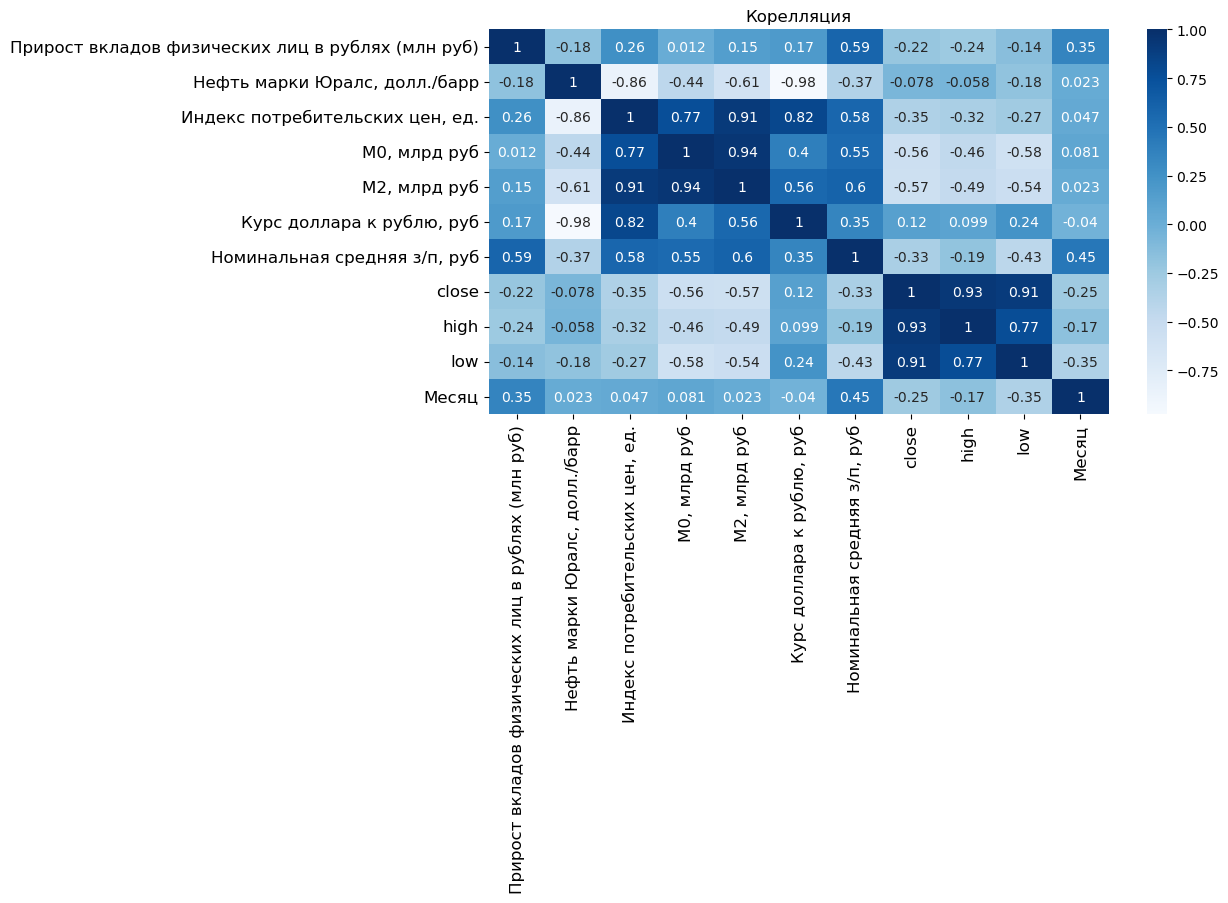

In [64]:
plt.figure(figsize=(10,5), dpi= 100)
sns.heatmap(df_clean.corr(), xticklabels=df_clean.corr().columns, yticklabels=df_clean.corr().columns, center=0, annot=True, cmap = 'Blues')
plt.title('Корелляция')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

## Теперь попробую Catboost без "лишних" признаков. Буду использовать grid_search.

In [65]:
df_train_val = df_clean[df_clean['Дата']<='2016-12-01']

In [66]:
y = df_train_val['Прирост вкладов физических лиц в рублях (млн руб)']
X = df_train_val.drop(columns = ['Прирост вкладов физических лиц в рублях (млн руб)'])

In [67]:
df_pred = df_clean[df_clean['Дата']>'2016-12-01']
X_pred = df_pred.drop(columns = ['Прирост вкладов физических лиц в рублях (млн руб)'])

In [68]:
# X_tr, X_test, y_tr, y_test = train_test_split(X, y, train_size=0.80, random_state=42, shuffle=False)

In [69]:
model_1 = CatBoostRegressor(loss_function='RMSE', random_seed=42, logging_level='Silent')

In [70]:
params = {'depth':[3,2,6,4,5,7,8,9,10],
          'iterations':[250,100,500, 1000],
          'learning_rate':[0.03,0.001,0.01,0.1,0.2,0.3]
         }

grid_search_result = model_1.grid_search(params, X, y, cv=5, refit = True, 
                                         plot = True,
                                         verbose = False,
                                         shuffle = False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

bestTest = 83748.33346 \
bestIteration = 126

In [71]:
# SCORE_catboost_1 = 

In [72]:
# model_1.fit(X_tr, y_tr, use_best_model=True, eval_set=(X_test, y_test))

In [73]:
# SCORE_catboost_1 = model_1.get_best_score()['validation']['RMSE']

In [74]:
# SCORE_catboost_1

In [75]:
# grid_search_result['cv_results']

In [76]:
SCORE_catboost_1 = np.min(grid_search_result['cv_results']['test-RMSE-mean'])
SCORE_catboost_1 

233026.33328327397

In [77]:
model_1.get_params()

{'loss_function': 'RMSE',
 'random_seed': 42,
 'logging_level': 'Silent',
 'depth': 2,
 'iterations': 1000,
 'learning_rate': 0.1}

### RMSE = 233026.33328327397
### or
### MAPE = 0.4862387

In [78]:
model_1.get_feature_importance()

array([ 0.08667734,  3.51882536,  2.20143851,  9.36375826,  1.47998354,
        0.98187958, 23.76116234,  3.95347509, 11.40203504,  9.88621862,
       33.36454633])

In [79]:
fi_catboost_1 = pd.DataFrame({'name': X.columns,'weight': model_1.feature_importances_})
fi_catboost_1.sort_values('weight',ascending=False,inplace=True)

### Feature importances Catboost (признаки удалены)
### Стоит отметить, что в модели основными признаками, повлиявшими на результат, были номинальная з/п, месяц, мультипликатор M0

In [80]:
fi_catboost_1

name     weight
10                            Месяц  33.364546
6      Номинальная средняя з/п, руб  23.761162
8                              high  11.402035
9                               low   9.886219
3                      М0, млрд руб   9.363758
7                             close   3.953475
1     Нефть марки Юралс, долл./барр   3.518825
2   Индекс потребительских цен, ед.   2.201439
4                      М2, млрд руб   1.479984
5         Курс доллара к рублю, руб   0.981880
0                              Дата   0.086677

In [81]:
PRED_catboost_1 = model_1.predict(X_pred)

In [82]:
pd.Series(PRED_catboost_1)

0    -364841.482355
1      42228.784816
2     181220.316035
3     264251.879730
4     244364.771443
5     228321.086668
6     271469.717736
7     197163.451285
8     244778.526690
9     245097.444044
10    222516.375397
11    778223.888494
dtype: float64

In [83]:
df_clean.loc[df_clean['Дата']>'2016-12-01','Прирост вкладов физических лиц в рублях (млн руб)'] = PRED_catboost_1

In [84]:
old = df_clean.loc[df_clean['Дата']<='2016-12-01',['Дата', 'Прирост вкладов физических лиц в рублях (млн руб)']].set_index('Дата')
old.shape

(38, 1)

In [85]:
pred_1 = df_clean.loc[df_clean['Дата']>='2016-12-01',['Дата', 'Прирост вкладов физических лиц в рублях (млн руб)']].set_index('Дата')
pred_1.shape

(13, 1)

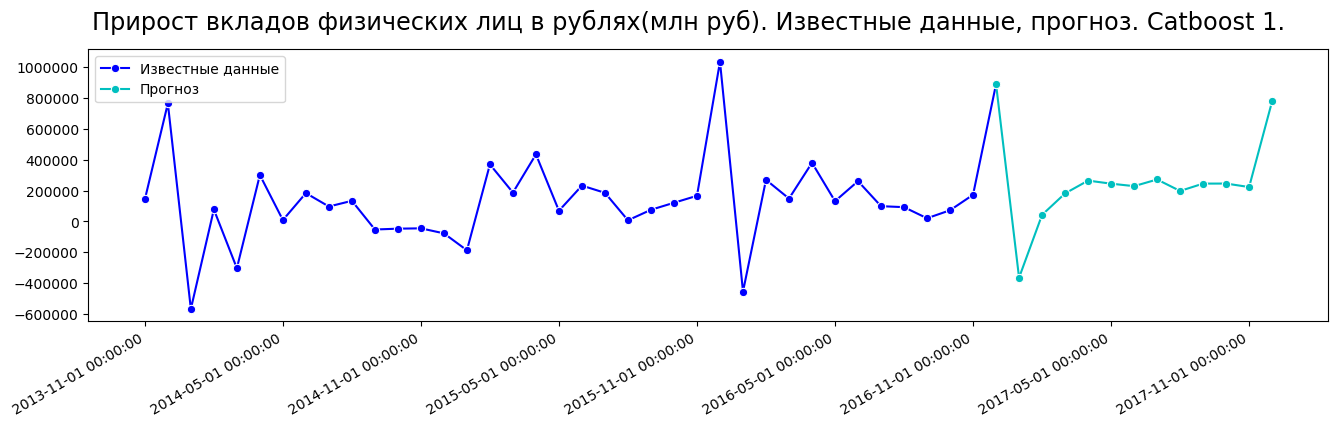

In [86]:
fig, ax = plot_series(old, pred_1, colors = ['b', 'c'],
      title = 'Прирост вкладов физических лиц в рублях(млн руб). Известные данные, прогноз. Catboost 1.', labels = ['Известные данные', 'Прогноз'])
plt.ticklabel_format(style='plain', axis='y')
fig.autofmt_xdate()

### Спрогнозированный результат

In [87]:
df_clean.tail(12)

Дата  Прирост вкладов физических лиц в рублях (млн руб)  \
38 2017-01-01                                     -364841.482355   
39 2017-02-01                                       42228.784816   
40 2017-03-01                                      181220.316035   
41 2017-04-01                                      264251.879730   
42 2017-05-01                                      244364.771443   
43 2017-06-01                                      228321.086668   
44 2017-07-01                                      271469.717736   
45 2017-08-01                                      197163.451285   
46 2017-09-01                                      244778.526690   
47 2017-10-01                                      245097.444044   
48 2017-11-01                                      222516.375397   
49 2017-12-01                                      778223.888494   

    Нефть марки Юралс, долл./барр  Индекс потребительских цен, ед.  \
38                          54.89                       166.434720   
39                          55.49                       166.800870   
40                          51.97                       167.017720   
41                          53.06                       167.568870   
42                          50.87                       168.188880   
43                          46.89                       169.214830   
44                          48.50                       169.333280   
45                          52.00                       168.418880   
46                          57.00                       168.166250   
47                          57.50                       168.502590   
48                          63.10                       168.852459   
49                          64.90                       169.560950   

    М0, млрд руб  М2, млрд руб  Курс доллара к рублю, руб  \
38   7714.777071  38417.973904                      59.96   
39   7543.682136  38016.827597                      58.39   
40   7587.379089  38462.292674                      58.10   
41   7610.346801  38555.203677                      56.43   
42   7775.286453  38663.774533                      57.17   
43   7813.342742  39222.853872                      57.82   
44   7946.920837  39623.111354                      59.67   
45   8034.188296  39275.911028                      59.65   
46   8066.772110  39419.314228                      57.73   
47   8089.527215  39570.988535                      57.71   
48   8071.528889  39667.451690                      58.92   
49   8073.942148  40114.408278                      58.59   

    Номинальная средняя з/п, руб  close   high    low  Месяц  
38                         34422  23.57  27.95  20.33      1  
39                         35497  27.35  27.58  21.51      2  
40                         37899  23.97  29.38  20.19      3  
41                         39225  22.47  26.90  21.72      4  
42                         39679  25.93  27.41  21.01      5  
43                         41454  22.55  30.92  21.29      6  
44                         38073  22.64  25.45  18.38      7  
45                         37099  19.80  23.50  17.88      8  
46                         38047  17.90  21.34  15.92      9  
47                         38333  17.07  18.28  13.80     10  
48                         38848  17.83  21.47  14.35     11  
49                         50500  18.54  21.23  14.91     12

### Описательные статистики

In [88]:
df_clean.describe()

Прирост вкладов физических лиц в рублях (млн руб)  \
count                                       5.000000e+01   
mean                                        1.587437e+05   
std                                         2.908547e+05   
min                                        -5.674480e+05   
25%                                         4.887834e+04   
50%                                         1.569040e+05   
75%                                         2.450177e+05   
max                                         1.034556e+06   

       Нефть марки Юралс, долл./барр  Индекс потребительских цен, ед.  \
count                      50.000000                        50.000000   
mean                       64.391400                       152.114721   
std                        24.877867                        15.302029   
min                        30.800000                       124.207680   
25%                        47.155000                       136.363902   
50%                        55.190000                       156.372005   
75%                        75.055000                       165.244430   
max                       111.870000                       169.560950   

       М0, млрд руб  М2, млрд руб  Курс доллара к рублю, руб  \
count     50.000000     50.000000                  50.000000   
mean    7150.465604  33896.553897                  55.242600   
std      488.209833   3641.763202                  12.556516   
min     6419.000000  28276.400000                  32.640000   
25%     6760.194233  30511.235312                  47.040000   
50%     7020.370413  32552.980370                  58.490000   
75%     7456.415989  36367.123236                  64.540000   
max     8089.527215  40114.408278                  77.220000   

       Номинальная средняя з/п, руб      close       high        low  \
count                     50.000000  50.000000   50.00000  50.000000   
mean                   35591.860000  31.928000   39.70500  26.999800   
std                     4298.278236  10.275138   17.47964   7.936642   
min                    29255.000000  17.070000   18.28000  13.800000   
25%                    32570.000000  24.000000   27.96000  20.987500   
50%                    34908.500000  31.655000   37.43000  27.020000   
75%                    38010.000000  36.357500   45.38000  31.430000   
max                    50500.000000  66.200000  121.41000  49.490000   

           Месяц  
count  50.000000  
mean    6.700000  
std     3.558548  
min     1.000000  
25%     4.000000  
50%     7.000000  
75%    10.000000  
max    12.000000

## Random Forest

In [89]:
X_forest_tr = X_tr.drop(columns = 'Дата')
X_forest_pred = X_val.drop(columns = 'Дата')

X_forest = X.drop(columns = 'Дата')
y_forest = y

In [90]:
X_forest_pred

Доходность ОФЗ по сроку до 1 года  Ключевая ставка  \
26                          10.308889             11.0   
27                           9.930476             11.0   
28                           9.505909             11.0   
29                           9.701905             11.0   
30                           9.538947             11.0   
31                           9.752857             10.5   
32                           9.606667             10.5   
33                           9.274348             10.5   
34                           9.015000             10.0   
35                           9.002381             10.0   
36                           8.936190             10.0   
37                           8.659545             10.0   

    Ставка по вкладам в долларах до 1 года  \
26                                    1.58   
27                                    1.62   
28                                    1.59   
29                                    1.30   
30                                    1.19   
31                                    0.97   
32                                    0.87   
33                                    0.89   
34                                    0.82   
35                                    0.71   
36                                    0.72   
37                                    0.76   

    Ставка по вкладам в рублях до 1 года  Нефть марки Юралс, долл./барр  \
26                                  8.20                          30.80   
27                                  7.68                          33.20   
28                                  7.46                          39.07   
29                                  7.67                          42.25   
30                                  7.04                          47.13   
31                                  6.92                          48.48   
32                                  6.78                          45.07   
33                                  6.77                          46.14   
34                                  6.00                          46.19   
35                                  6.01                          49.73   
36                                  6.62                          46.44   
37                                  6.50                          54.07   

    Индекс потребительских цен, ед.  М0, млрд руб  М2, млрд руб  \
26                        158.47866   7239.145905  35179.714815   
27                        159.47707   7055.140825  33966.453991   
28                        160.21067   7149.795460  34309.649661   
29                        160.91559   7142.892260  34689.448390   
30                        161.57535   7301.487971  35105.469375   
31                        162.15702   7296.764604  35642.933649   
32                        163.03267   7372.703720  35856.891826   
33                        163.04897   7462.394809  36031.670782   
34                        163.32615   7438.479529  36169.577926   
35                        164.02846   7412.196989  36148.750479   
36                        164.75018   7339.148803  36051.043468   
37                        165.40918   7317.233222  36432.971673   

    Курс доллара к рублю, руб  Номинальная средняя з/п, руб   open  close  \
26                      76.25                         32660  37.36  41.20   
27                      77.22                         33873  41.18  43.25   
28                      70.47                         35501  43.53  34.39   
29                      66.68                         36497  35.52  35.33   
30                      65.66                         37270  35.56  33.63   
31                      65.31                         38447  33.61  34.18   
32                      64.33                         35888  34.42  24.97   
33                      64.92                         35405  25.01  28.08   
34                      64.60                         35843  28.08  25.83   
35                      62.68   

In [91]:
rf = RandomForestRegressor(n_estimators=100, max_depth=2, min_samples_split=2)

rf.fit(X_forest_tr, y_tr)

y_pred = rf.predict(X_forest_pred)

accuracy = rf.score(X_forest_pred, y_val)
accuracy

0.06430704337687698

In [92]:
PRED_randomforest = y_pred

In [93]:
SCORE_randomforest = -(cross_val_score(rf, X_forest, y,
                         scoring='neg_root_mean_squared_error', cv=5).mean())
SCORE_randomforest

258138.40109479093

### RMSE = 2500000 approximately

In [94]:
fi_forest = pd.DataFrame({'name': X_forest_tr.columns,'weight': rf.feature_importances_})
fi_forest.sort_values('weight',ascending=False,inplace=True)

### Feature importances Random Forest Regressor

In [95]:
fi_forest

name    weight
6                             М0, млрд руб  0.208972
14                                   Месяц  0.143495
9             Номинальная средняя з/п, руб  0.137283
7                             М2, млрд руб  0.091752
5          Индекс потребительских цен, ед.  0.087482
13                                     low  0.061417
8                Курс доллара к рублю, руб  0.060928
12                                    high  0.059177
11                                   close  0.052553
4            Нефть марки Юралс, долл./барр  0.050946
10                                    open  0.018640
1                          Ключевая ставка  0.013090
0        Доходность ОФЗ по сроку до 1 года  0.006748
3     Ставка по вкладам в рублях до 1 года  0.006162
2   Ставка по вкладам в долларах до 1 года  0.001355

In [96]:
y_pred

array([304724.55819764, 362219.53495039, 369711.98233134, 253922.89325929,
       282997.57622309, 306830.78955643, 217261.57855993, 218647.9008208 ,
       205942.36396366, 200789.90752888, 204710.47970279, 451551.5803885 ])

In [97]:
df_forest = df_clean.copy()

In [98]:
df_forest.loc[df_forest['Дата']>'2016-12-01','Прирост вкладов физических лиц в рублях (млн руб)'] = y_pred

In [99]:
old = df_clean.loc[df_clean['Дата']<='2016-12-01',['Дата', 'Прирост вкладов физических лиц в рублях (млн руб)']].set_index('Дата')
old.shape

(38, 1)

In [100]:
pred_forest = df_forest.loc[df_forest['Дата']>='2016-12-01',['Дата', 'Прирост вкладов физических лиц в рублях (млн руб)']].set_index('Дата')
pred_forest.shape

(13, 1)

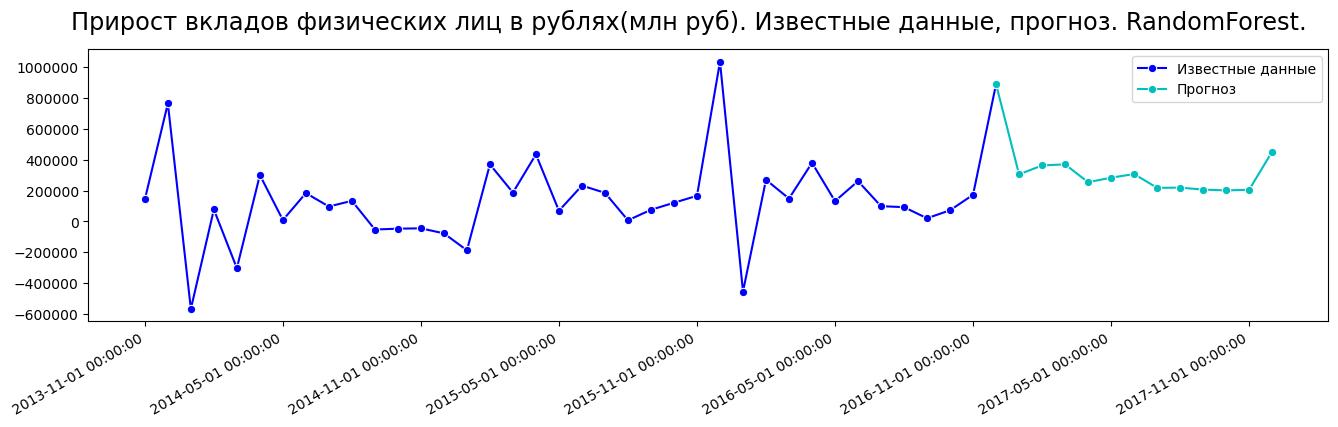

In [101]:
fig, ax = plot_series(old, pred_forest, colors = ['b', 'c'],
      title = 'Прирост вкладов физических лиц в рублях(млн руб). Известные данные, прогноз. RandomForest.', labels = ['Известные данные', 'Прогноз'])
plt.ticklabel_format(style='plain', axis='y')
fig.autofmt_xdate()

In [102]:
df_forest.tail(12)

Дата  Прирост вкладов физических лиц в рублях (млн руб)  \
38 2017-01-01                                      304724.558198   
39 2017-02-01                                      362219.534950   
40 2017-03-01                                      369711.982331   
41 2017-04-01                                      253922.893259   
42 2017-05-01                                      282997.576223   
43 2017-06-01                                      306830.789556   
44 2017-07-01                                      217261.578560   
45 2017-08-01                                      218647.900821   
46 2017-09-01                                      205942.363964   
47 2017-10-01                                      200789.907529   
48 2017-11-01                                      204710.479703   
49 2017-12-01                                      451551.580389   

    Нефть марки Юралс, долл./барр  Индекс потребительских цен, ед.  \
38                          54.89                       166.434720   
39                          55.49                       166.800870   
40                          51.97                       167.017720   
41                          53.06                       167.568870   
42                          50.87                       168.188880   
43                          46.89                       169.214830   
44                          48.50                       169.333280   
45                          52.00                       168.418880   
46                          57.00                       168.166250   
47                          57.50                       168.502590   
48                          63.10                       168.852459   
49                          64.90                       169.560950   

    М0, млрд руб  М2, млрд руб  Курс доллара к рублю, руб  \
38   7714.777071  38417.973904                      59.96   
39   7543.682136  38016.827597                      58.39   
40   7587.379089  38462.292674                      58.10   
41   7610.346801  38555.203677                      56.43   
42   7775.286453  38663.774533                      57.17   
43   7813.342742  39222.853872                      57.82   
44   7946.920837  39623.111354                      59.67   
45   8034.188296  39275.911028                      59.65   
46   8066.772110  39419.314228                      57.73   
47   8089.527215  39570.988535                      57.71   
48   8071.528889  39667.451690                      58.92   
49   8073.942148  40114.408278                      58.59   

    Номинальная средняя з/п, руб  close   high    low  Месяц  
38                         34422  23.57  27.95  20.33      1  
39                         35497  27.35  27.58  21.51      2  
40                         37899  23.97  29.38  20.19      3  
41                         39225  22.47  26.90  21.72      4  
42                         39679  25.93  27.41  21.01      5  
43                         41454  22.55  30.92  21.29      6  
44                         38073  22.64  25.45  18.38      7  
45                         37099  19.80  23.50  17.88      8  
46                         38047  17.90  21.34  15.92      9  
47                         38333  17.07  18.28  13.80     10  
48                         38848  17.83  21.47  14.35     11  
49                         50500  18.54  21.23  14.91     12

## Linear regression

### Разобью категориальную переменную столбца "Месяц" на несколько столбцов. В Catboost и RandomForest это менее критично, а линейная регрессия может неправильно настроить коэффиценты из-за категориальной переменной, подумав, что месяцы с более большимим значениями более важны

In [103]:
df_reg = pd.get_dummies(df_clean, prefix='Месяц', columns=['Месяц'])

In [104]:
df_reg.head()

Дата  Прирост вкладов физических лиц в рублях (млн руб)  \
0 2013-11-01                                           142125.0   
1 2013-12-01                                           764180.0   
2 2014-01-01                                          -567448.0   
3 2014-02-01                                            77197.0   
4 2014-03-01                                          -303341.0   

   Нефть марки Юралс, долл./барр  Индекс потребительских цен, ед.  \
0                         108.08                        124.20768   
1                         110.63                        124.84114   
2                         107.57                        125.57770   
3                         108.81                        126.45675   
4                         107.41                        127.74660   

   М0, млрд руб  М2, млрд руб  Курс доллара к рублю, руб  \
0        6419.0       28276.4                      32.64   
1        6564.1       28873.3                      32.89   
2        6985.6       31155.6                      33.46   
3        6663.1       29861.2                      35.22   
4        6699.9       30169.0                      36.21   

   Номинальная средняя з/п, руб  close   high  ...  Месяц_3  Месяц_4  Месяц_5  \
0                         30290  23.80  24.43  ...        0        0        0   
1                         39648  20.48  26.49  ...        0        0        0   
2                         29535  27.48  29.04  ...        0        0        0   
3                         29255  28.38  29.84  ...        0        0        0   
4                         31486  38.84  70.63  ...        1        0        0   

   Месяц_6  Месяц_7  Месяц_8  Месяц_9  Месяц_10  Месяц_11  Месяц_12  
0        0        0        0        0         0         1         0  
1        0        0        0        0         0         0         1  
2        0        0        0        0         0         0         0  
3        0        0        0        0         0         0         0  
4        0        0        0        0         0         0         0  

[5 rows x 23 columns]

In [105]:
df_train_val = df_reg[df_reg['Дата']<='2016-12-01']

In [106]:
y = df_train_val['Прирост вкладов физических лиц в рублях (млн руб)']
X = df_train_val.drop(columns = ['Дата','Прирост вкладов физических лиц в рублях (млн руб)'])

In [107]:
df_pred = df_reg[df_clean['Дата']>='2016-12-01']
pred_dates = df_reg[df_clean['Дата']>='2016-12-01']['Дата']
X_pred = df_pred.drop(columns = ['Дата','Прирост вкладов физических лиц в рублях (млн руб)'])

In [108]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.70, random_state=42, shuffle=False)

In [109]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

In [110]:
scores = cross_val_score(lin_reg, X_val, y_val,
                         scoring='neg_root_mean_squared_error', cv=5)
scores

array([ -440952.21413858,  -270759.09854009,  -233824.3903312 ,
        -110038.01923518, -1171544.43328269])

In [111]:
SCORE_linearregression = -(cross_val_score(lin_reg, X_val, y_val,
                         scoring='neg_root_mean_squared_error', cv=5).mean())
SCORE_linearregression

445423.6311055495

### RMSE = 445423.6311055495

In [112]:
fi_lin = pd.DataFrame({'name': X_train.columns,'weight': lin_reg.coef_})
fi_lin.sort_values('weight',ascending=False,inplace=True)

### Feature importances LinearRegression

In [113]:
fi_lin

name         weight
20                         Месяц_12  391575.645722
15                          Месяц_7   83525.727255
16                          Месяц_8   75820.583591
8                               low   50389.135357
10                          Месяц_2   35904.532804
19                         Месяц_11   14366.301977
0     Нефть марки Юралс, долл./барр   12748.542751
4         Курс доллара к рублю, руб   10226.777183
1   Индекс потребительских цен, ед.    9299.720407
12                          Месяц_4    8190.297842
5      Номинальная средняя з/п, руб      59.462061
3                      М2, млрд руб      24.265134
2                      М0, млрд руб    -544.226353
7                              high   -8988.498287
6                             close  -16298.238628
9                           Месяц_1  -26397.792063
18                         Месяц_10  -49655.075026
11                          Месяц_3 -100801.036316
17                          Месяц_9 -107524.351928
14                          Месяц_6 -131518.039687
13                          Месяц_5 -193486.794173

### декабрь - 13 зарплата
### low - российский индекс волатильности

In [114]:
y_pred_reg = lin_reg.predict(X_pred)

In [115]:
PRED_linearregression = y_pred_reg[1:13]

In [116]:
pred_reg = pd.DataFrame({'Прирост вкладов физических лиц в рублях (млн руб)':y_pred_reg}, index = pred_dates)

In [117]:
pred_reg

Прирост вкладов физических лиц в рублях (млн руб)
Дата                                                         
2016-12-01                                       1.051502e+06
2017-01-01                                      -2.455093e+05
2017-02-01                                      -3.972895e+04
2017-03-01                                      -1.200073e+05
2017-04-01                                       1.833625e+05
2017-05-01                                      -1.897867e+05
2017-06-01                                      -2.632127e+04
2017-07-01                                      -1.336890e+05
2017-08-01                                      -1.806966e+05
2017-09-01                                      -3.285478e+05
2017-10-01                                      -3.188709e+05
2017-11-01                                      -1.384168e+05
2017-12-01                                       9.861413e+05

# Выводы

## Визуализация всех моделей

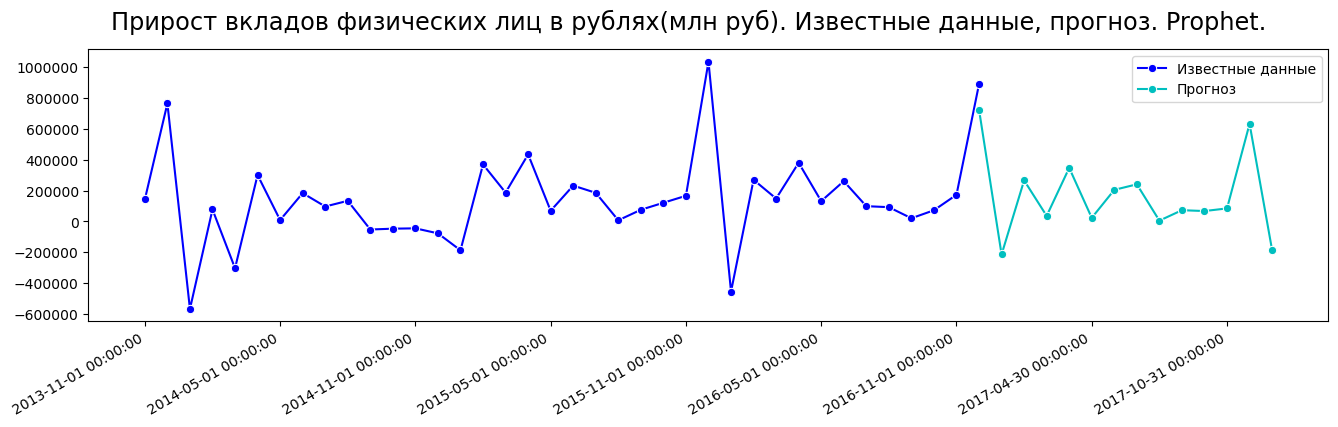

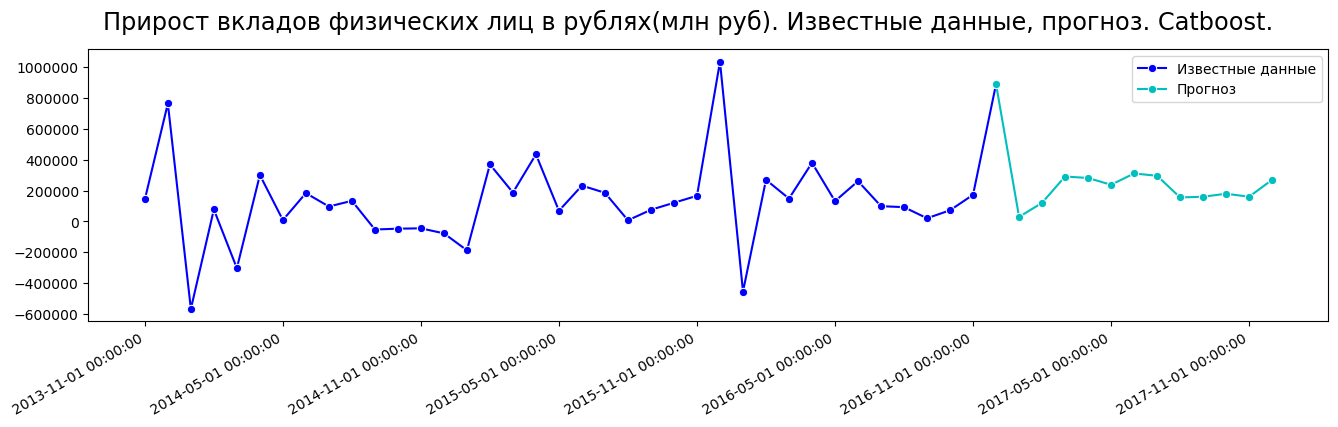

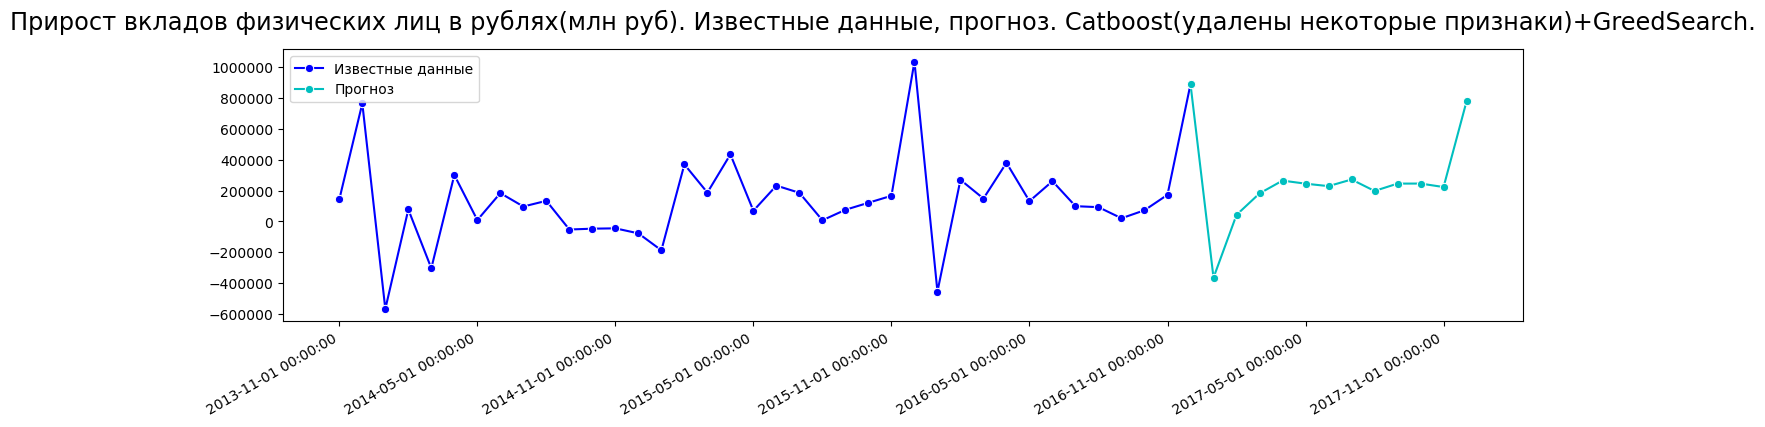

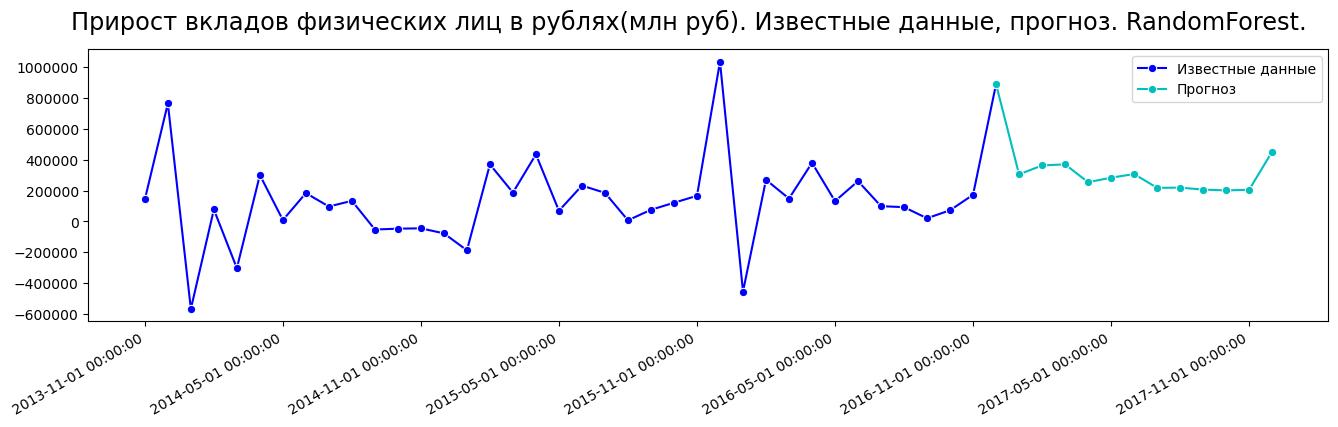

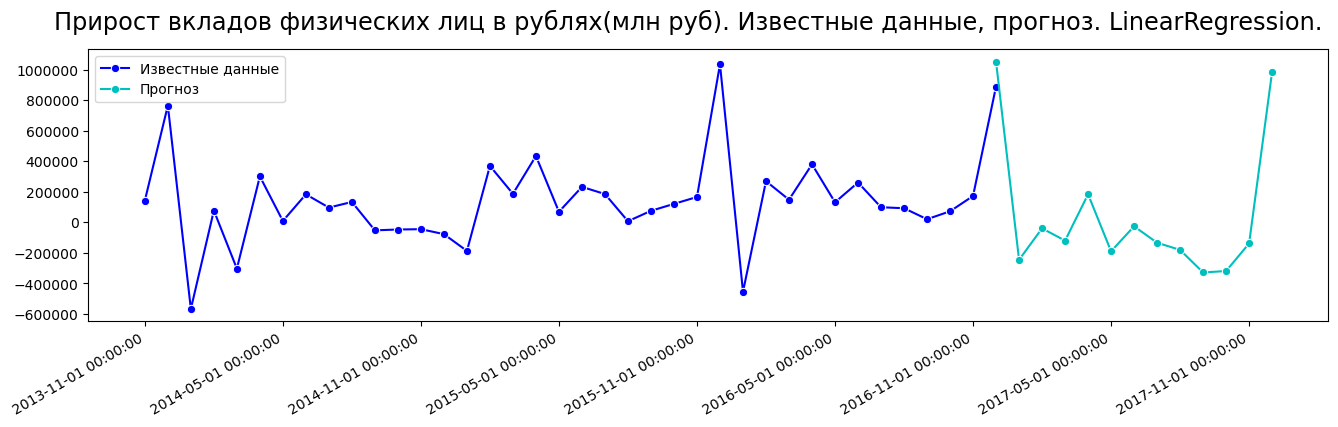

In [118]:
fig, ax = plot_series(old, pred_prophet, colors = ['b', 'c'],
      title = 'Прирост вкладов физических лиц в рублях(млн руб). Известные данные, прогноз. Prophet.', labels = ['Известные данные', 'Прогноз'])
fig.autofmt_xdate()
plt.ticklabel_format(style='plain', axis='y')

fig, ax = plot_series(old, pred_0, colors = ['b', 'c'],
      title = 'Прирост вкладов физических лиц в рублях(млн руб). Известные данные, прогноз. Catboost.', labels = ['Известные данные', 'Прогноз'])
fig.autofmt_xdate()
plt.ticklabel_format(style='plain', axis='y')

fig, ax = plot_series(old, pred_1, colors = ['b', 'c'],
      title = 'Прирост вкладов физических лиц в рублях(млн руб). Известные данные, прогноз. Catboost(удалены некоторые признаки)+GreedSearch.', labels = ['Известные данные', 'Прогноз'])
fig.autofmt_xdate()
plt.ticklabel_format(style='plain', axis='y')

fig, ax = plot_series(old, pred_forest, colors = ['b', 'c'],
      title = 'Прирост вкладов физических лиц в рублях(млн руб). Известные данные, прогноз. RandomForest.', labels = ['Известные данные', 'Прогноз'])
fig.autofmt_xdate()
plt.ticklabel_format(style='plain', axis='y')

fig, ax = plot_series(old, pred_reg, colors = ['b', 'c'],
      title = 'Прирост вкладов физических лиц в рублях(млн руб). Известные данные, прогноз. LinearRegression.', labels = ['Известные данные', 'Прогноз'])
fig.autofmt_xdate()
plt.ticklabel_format(style='plain', axis='y')

In [119]:
PRED_results = pd.DataFrame({'Prophet':PRED_prophet, 'Catboost_0':PRED_catboost_0, 'Catboost_1':PRED_catboost_1, 
               'RandomForest':PRED_randomforest, 'LinearRegression':PRED_linearregression}, index = pred_dates[1:13])

In [120]:
PRED_results

Prophet     Catboost_0     Catboost_1   RandomForest  \
Дата                                                                     
2017-01-01  265532.712772   29041.043226 -364841.482355  304724.558198   
2017-02-01   35530.533068  120213.667826   42228.784816  362219.534950   
2017-03-01  346699.597994  290798.298718  181220.316035  369711.982331   
2017-04-01   22986.032328  281098.459912  264251.879730  253922.893259   
2017-05-01  204293.853877  237330.860212  244364.771443  282997.576223   
2017-06-01  240203.296994  310461.908121  228321.086668  306830.789556   
2017-07-01    4840.221291  295442.184927  271469.717736  217261.578560   
2017-08-01   72538.234745  155146.305515  197163.451285  218647.900821   
2017-09-01   67032.546579  159693.358501  244778.526690  205942.363964   
2017-10-01   84095.212131  179220.008664  245097.444044  200789.907529   
2017-11-01  631924.256670  159693.358501  222516.375397  204710.479703   
2017-12-01 -186432.954619  269420.716588  778223.888494  451551.580389   

            LinearRegression  
Дата                          
2017-01-01    -245509.255170  
2017-02-01     -39728.950843  
2017-03-01    -120007.313210  
2017-04-01     183362.523202  
2017-05-01    -189786.711670  
2017-06-01     -26321.270295  
2017-07-01    -133689.046305  
2017-08-01    -180696.649462  
2017-09-01    -328547.805826  
2017-10-01    -318870.930185  
2017-11-01    -138416.755298  
2017-12-01     986141.341227

In [121]:
SCORE_results = pd.DataFrame({'Prophet':np.nan, 'Catboost_0':SCORE_catboost_0, 'Catboost_1':SCORE_catboost_1, 
               'RandomForest':SCORE_randomforest, 'LinearRegression':SCORE_linearregression}, index = ['RMSE'])
SCORE_results

Prophet     Catboost_0     Catboost_1   RandomForest  LinearRegression
RMSE      NaN  282762.892728  233026.333283  258138.401095     445423.631106

## С точки зрения экономической логики наиболее подходящими моделями являются модель, построенная с помощью библиотеки для анализа и прогнозирования временных рядов, Prophet, а также модель машинного обучения LinearRegression

### Несмотря на то, что Prophet не опирался ни на какие признаки при анализе временного ряда, можно сказать, что если сохранятся восходящий тренд и сезонность, то модель Prophet будет актуальной 

### Несмотря на то, что RMSE(Среднеквадратическое отклонение) у линейной регрессии хуже, чем у других моделей (Catboost, RandomForest), на графике можно заметить, опираясь значения прошлых лет, что сезонность была предсказана приблизительно верно

Временные ряды часто содержат тренды и сезонность, что делает RMSE недостаточным для оценки качества моделей. RMSE измеряет только среднюю ошибку прогнозирования, но может игнорировать важные аспекты динамики временных рядов, такие как тренды и циклы.

Временные ряды могут иметь автокорреляцию, то есть зависимость между значениями в разные моменты времени. Это означает, что ошибки прогнозирования могут быть взаимосвязаны и не случайны. RMSE не учитывает эту структуру зависимости, поэтому он может быть неинформативным в оценке точности модели.

Временные ряды могут иметь большое количество "шума". RMSE может быть чувствительным к таким случайным отклонениям и приводить к переоценке моделей, особенно если они хорошо справляются с основными трендами и сезонностью.